In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('test_dataset.csv')
df.head()

,date,racecourse_country,racecourse_name,race_time,race_id,race_distance,race_type,race_type_simple,going_clean,n_runners,horse_id,horse_name,age,official_rating,carried_weight,draw,jockey_id,jockey_name,trainer_id,trainer_name,ltp_5min,obs__bsp,obs__racing_post_rating,obs__Place,obs__uposition,obs__is_winner,obs__top_speed,obs__distance_to_winner,obs__pos_prize,obs__completion_time
0,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,21374,Eton Rambler,5,73.0,59.874193,3,5362,Pat Cosgrave,375,George Baker,7.8,9.12,82.0,3,3,0,48.0,2.5,721.50,155.95
1,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,21378,Shades Of Silver,5,69.0,58.059823,6,7227,William Twiston-Davies,367,Michael Scudamore,5.8,7.00,81.0,2,2,0,47.0,0.5,1443.75,155.61
2,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,26461,Marengo,4,69.0,54.884677,8,12949,Jordan Williams,762,Bernard Llewellyn,12.0,9.28,45.0,8,8,0,11.0,23.0,0.00,159.36
3,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,50069,Smoker,5,70.0,58.513416,2,5425,Oisin Murphy,126,Tim Vaughan,34.0,18.00,62.0,6,6,0,28.0,13.0,0.00,157.70
4,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,102542,Symphony Of Kings,4,74.0,60.327785,4,5481,Adam Kirby,414,Tony Carroll,7.6,7.40,77.0,5,5,0,44.0,6.0,0.00,156.53


## Initial EDA
- check for Nan's
- Check for outliers in the data

In [3]:
# check for NaN's
# nan_counts = df.isna().sum
# print(nan_counts)

In [4]:
# returns a list of unique values
df["draw"].value_counts().head(10)

draw
0    316024
3     44689
2     44624
1     44624
4     44359
5     43663
6     41756
7     38632
8     34433
9     29517
Name: count, dtype: int64

In [5]:
# returns a list of unique values
df["draw"].value_counts().head(10)


draw
0    316024
3     44689
2     44624
1     44624
4     44359
5     43663
6     41756
7     38632
8     34433
9     29517
Name: count, dtype: int64

We can see that there is a high number of values with a draw value of 0. From my experience draw values are 1 or greater (for flat races).
This warrants further investigation as 'Draw' is known to have a major impact on the probabilities 
of horses winning at particular tracks and particular distancesin flat races.

We are going to investigate if any flat races are affected by 'draw' == 0.

In [6]:
# Group by race_id and race_type_simple, then check if any draw == 0 in that race
draw_zero_races = (
    df.groupby(['race_id', 'race_type_simple'])['draw']
      .apply(lambda x: (x == 0).any())
      .reset_index(name='has_draw_zero')
)

# Now see which race types have races with draw == 0
draw_zero_counts = draw_zero_races.groupby('race_type_simple')['has_draw_zero'].sum().sort_values(ascending=False)
print(draw_zero_counts)

race_type_simple
Hurdle       18471
Chase        12055
Flat Turf     3075
Flat AW        174
Name: has_draw_zero, dtype: int64


Design a function that can be used to visualize the counts of selected columns.

In [7]:
def plot_histogram(df, column, bins=30):
    plt.figure(figsize=(8,5))
    plt.hist(df[column].dropna(), bins=bins, edgecolor='black', alpha=0.7)
    plt.axvline(df[column].mean(), color='red', linestyle='--', label=f"Mean: {df[column].mean():.2f}")
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

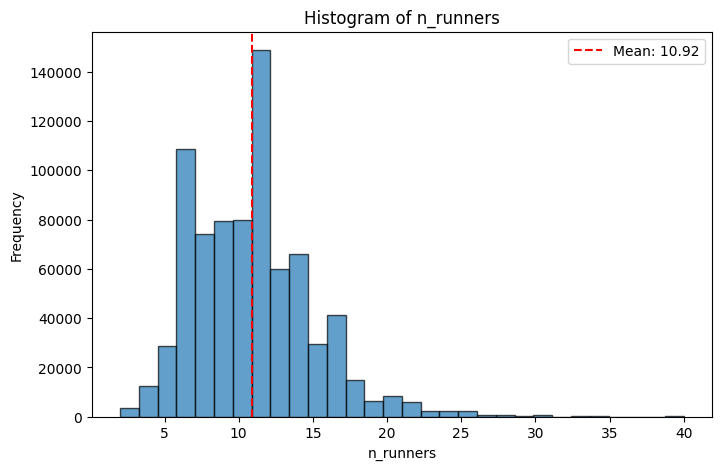

In [8]:
plot_histogram(df, "n_runners")


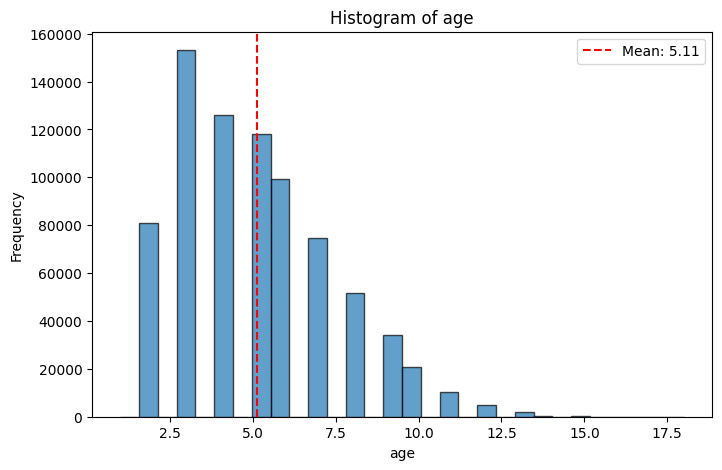

In [9]:
plot_histogram(df,'age')

## Data Cleaning and Feature Engineering

With the numeric columns, it is essential that there are no NaN values.
With the numeric columns all NaN's will be replaced with 0.

In [10]:
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

I am going to create a feature called draw_iv. This feature is used to show the impact value of a draw
by 'racecourse_name', 'race_distance', 'race_type' and 'going_clean'. I have done this as previous analysis
has shown the significant impact on stall number for flat races at particular racetracks.

Due to the large number of flat races where we don't have values for 'draw' I may not use this in the modelling 
but I felt it was an important area to highlight for this assessment.

In [11]:
# create a draw IV feature.

# Columns: racecourse_name, race_distance, race_type, going_clean, draw, obs__is_winner
group_cols = ['racecourse_name', 'race_distance', 'race_type', 'going_clean', 'draw']

draw_stats = df.groupby(group_cols)['obs__is_winner'].agg(['sum', 'count']).reset_index()
draw_stats['win_pct'] = draw_stats['sum'] / draw_stats['count']

# Overall win rate per race conditions
overall_win_pct = df.groupby(['racecourse_name', 'race_distance', 'race_type', 'going_clean'])['obs__is_winner'].mean().reset_index()
overall_win_pct = overall_win_pct.rename(columns={'obs__is_winner':'overall_win_pct'})

# Merge with draw stats
draw_stats = draw_stats.merge(overall_win_pct, on=['racecourse_name', 'race_distance', 'race_type', 'going_clean'])
draw_stats['draw_iv'] = draw_stats['win_pct'] / draw_stats['overall_win_pct']

df = df.merge(draw_stats[['racecourse_name', 'race_distance', 'race_type', 'going_clean','draw', 'draw_iv']], 
              on=['racecourse_name', 'race_distance', 'race_type', 'going_clean', 'draw'], 
              how='left')


### Create rank columns
- I am going to create some features that are derived from existing features in the dataset that could be useful for 
creating models with greater powers of prediction.
- This allows us to use a horses relative rank in a model instead of it's absolute value,
this can be very useful when a horse is moving between classes.

### create a feature that indicates the rank of ltp_5min for each horse, race combination

In [ ]:
df['ltp_rank'] = (
    df.groupby(['date', 'racecourse_name', 'race_time'])['ltp_5min']
    .rank(method='min', ascending=True)
)

### create a feature that indicates the rank of official_rating for each horse, race combination


In [ ]:
df['rating_rank'] = (
    df.groupby(['date', 'racecourse_name', 'race_time'])['official_rating']
    .rank(method='min', ascending=False)
)

### Create a column that shows the career max speed achieved by a horse

In [15]:
# Store original index
df['original_index'] = df.index

# Ensure obs__top_speed NaNs are 0
df['obs__top_speed'] = df['obs__top_speed'].fillna(0)

# Sort by horse and date
df = df.sort_values(['horse_id', 'date'])

# Compute max_top_speed_prev per horse
df['max_top_speed_prev'] = df.groupby('horse_id')['obs__top_speed'].transform(
    lambda s: s.shift(1).cummax().fillna(0)
)

# Restore original order
df = df.sort_values('original_index').drop(columns=['original_index']).reset_index(drop=True)


In [23]:
df.head()

,date,racecourse_country,racecourse_name,race_time,race_id,race_distance,race_type,race_type_simple,going_clean,n_runners,horse_id,horse_name,age,official_rating,carried_weight,draw,jockey_id,jockey_name,trainer_id,trainer_name,ltp_5min,obs__bsp,obs__racing_post_rating,obs__Place,obs__uposition,obs__is_winner,obs__top_speed,obs__distance_to_winner,obs__pos_prize,obs__completion_time,draw_iv,ltp_rank,rating_rank,max_top_speed_prev
0,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,21374,Eton Rambler,5,73.0,59.874193,3,5362,Pat Cosgrave,375,George Baker,7.8,9.12,82.0,3,3,0,48.0,2.5,721.50,155.95,0.000000,5.0,3.0,0.0
1,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,21378,Shades Of Silver,5,69.0,58.059823,6,7227,William Twiston-Davies,367,Michael Scudamore,5.8,7.00,81.0,2,2,0,47.0,0.5,1443.75,155.61,0.854545,3.0,5.0,0.0
2,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,26461,Marengo,4,69.0,54.884677,8,12949,Jordan Williams,762,Bernard Llewellyn,12.0,9.28,45.0,8,8,0,11.0,23.0,0.00,159.36,0.000000,6.0,5.0,0.0
3,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,50069,Smoker,5,70.0,58.513416,2,5425,Oisin Murphy,126,Tim Vaughan,34.0,18.00,62.0,6,6,0,28.0,13.0,0.00,157.70,0.854545,7.0,4.0,0.0
4,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,102542,Symphony Of Kings,4,74.0,60.327785,4,5481,Adam Kirby,414,Tony Carroll,7.6,7.40,77.0,5,5,0,44.0,6.0,0.00,156.53,1.709091,4.0,1.0,0.0


## EDA

In [26]:
# Look at the proportions for various features

def calculate_proportions(df, column_name):
    proportions = df[column_name].value_counts(normalize=True).round(3).sort_index(ascending=True)
    return proportions

Below we can see at 34.2% of the time, across all race types that the horse with the lowest value for 'ltp_5min'
will win the race.

In [28]:
winners = df[df['obs__is_winner'] == 1]

win_props = calculate_proportions(winners, 'ltp_rank')
win_props.head(10)

ltp_rank
1.0     0.342
2.0     0.202
3.0     0.138
4.0     0.097
5.0     0.071
6.0     0.049
7.0     0.034
8.0     0.024
9.0     0.015
10.0    0.010
Name: proportion, dtype: float64

Below we can see that 32.6% of the time, across all race types that the horse with the highest value for 'official_rating'
will win the race.

In [30]:
rating_props = calculate_proportions(winners, 'rating_rank')
rating_props.head(10)

rating_rank
1.0     0.326
2.0     0.166
3.0     0.121
4.0     0.093
5.0     0.074
6.0     0.059
7.0     0.046
8.0     0.034
9.0     0.025
10.0    0.019
Name: proportion, dtype: float64